In [7]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm

# Fetch data for US Dollar Index (DXY) and S&P 500 (^GSPC)
start_date = "2010-01-01"
end_date = "2025-01-21"

usd_index = yf.download("DX-Y.NYB", start=start_date, end=end_date)['Close']
sp500 = yf.download("^GSPC", start=start_date, end=end_date)['Close']

# Align the data
data = pd.concat([usd_index, sp500], axis=1).dropna()
data.columns = ['USD_Index', 'SP500']

# Compute daily returns
returns = data.pct_change().dropna()

# Regression: SP500_return ~ USD_Index_return
X = sm.add_constant(returns['USD_Index'])
y = returns['SP500']

model = sm.OLS(y, X).fit()

# Print regression summary
print(model.summary())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                            OLS Regression Results                            
Dep. Variable:                  SP500   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     159.8
Date:                Wed, 21 Jan 2026   Prob (F-statistic):           6.73e-36
Time:                        19:26:57   Log-Likelihood:                 11819.
No. Observations:                3782   AIC:                        -2.363e+04
Df Residuals:                    3780   BIC:                        -2.362e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      3.176      0.0

In [4]:
from dataloader import load_log_returns, load_symbols
from mapper import build_fx_map


symbols = load_symbols(source="csv", csv_path="acg_macro_signal.csv")

fx_map, fx_exempt = build_fx_map(symbols)

returns = load_log_returns(symbols, fx_map, broker_name="acg", lookback_days=252)

index = returns.mean(axis=1)

Updating DB from 2026-01-21 to today...
2026-01-22 00:00:00
No new MT5 data available.


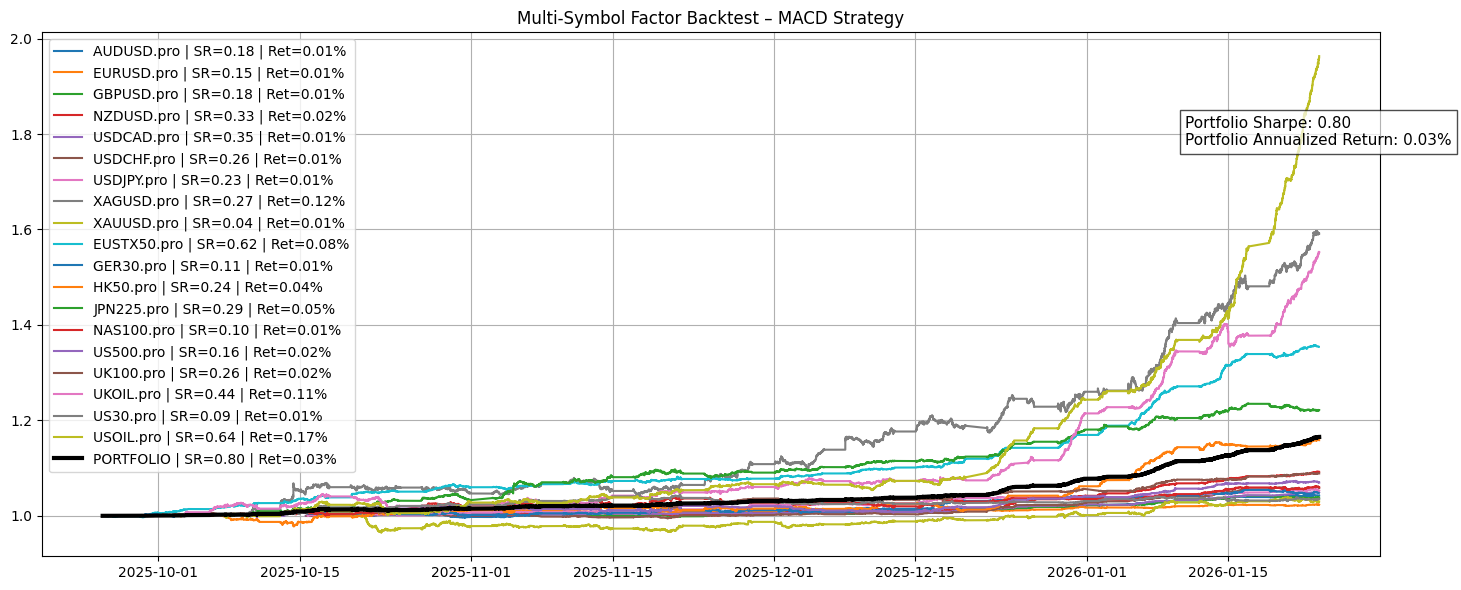

In [1]:
import MetaTrader5 as mt5
import pandas as pd
from backtest import backtest_symbols, fetch_mt5_data
from factorsignal import generate_signal
from brokers import get_broker

broker = get_broker("acg")
broker.initialize()

timeframe = mt5.TIMEFRAME_M1

factor = "macd"
symbols = pd.read_csv("acg_macro_signal.csv", header=None, sep="\t")[0].tolist()
perf, returns_factor_pr = backtest_symbols(symbols, factor=factor, timeframe=timeframe)


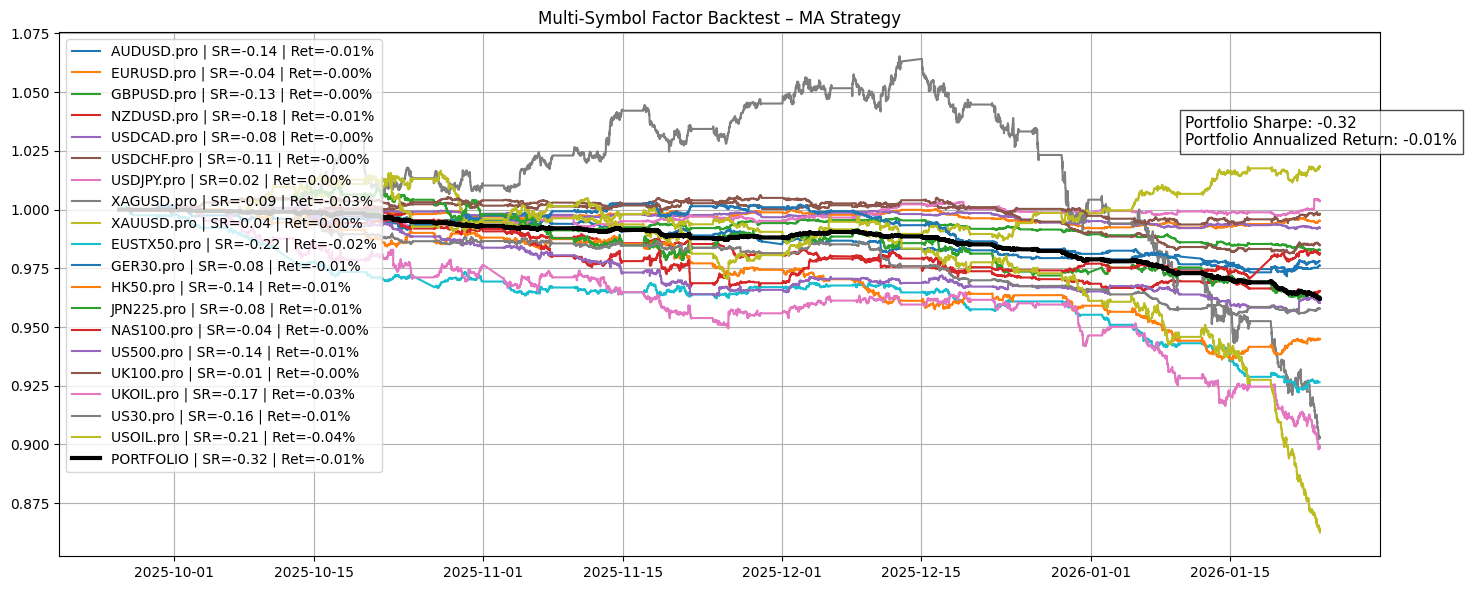

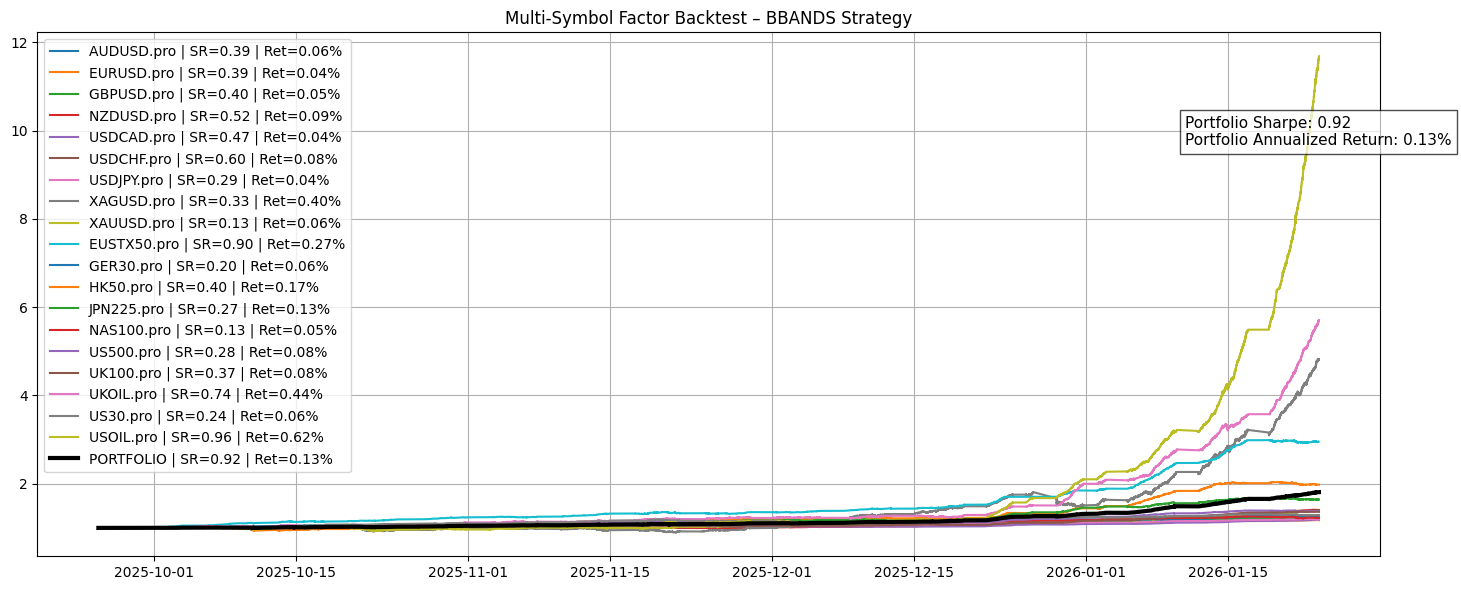

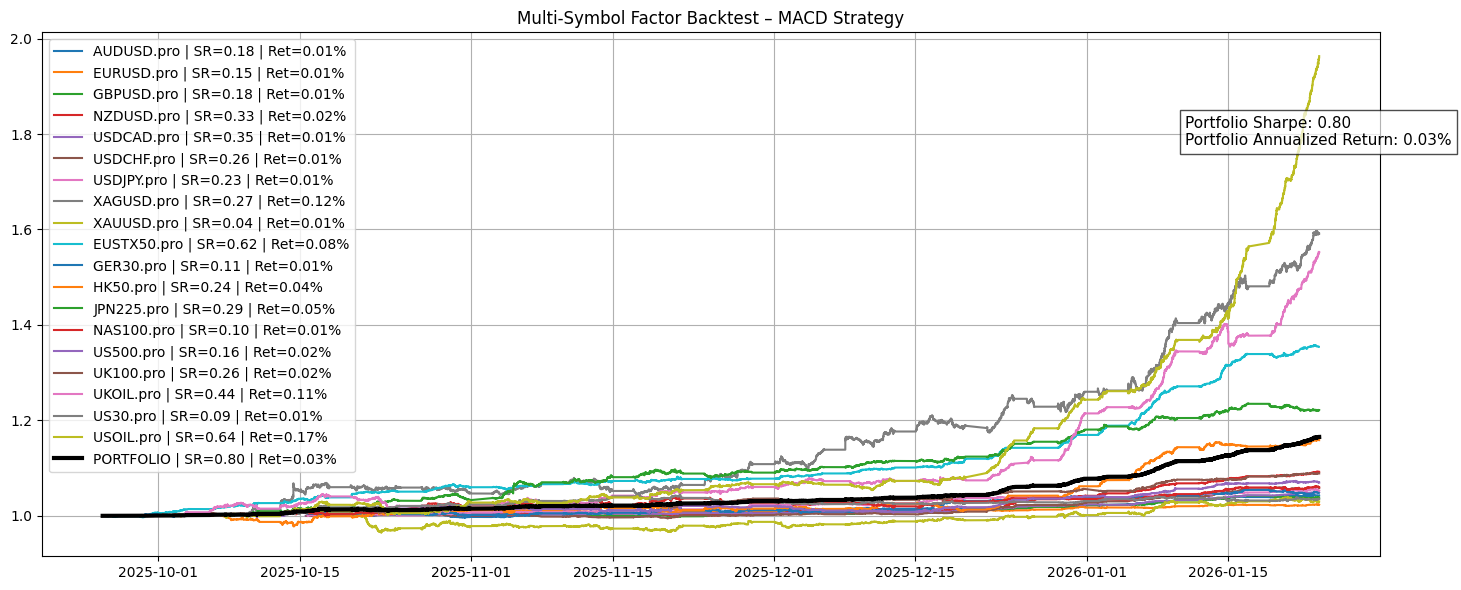

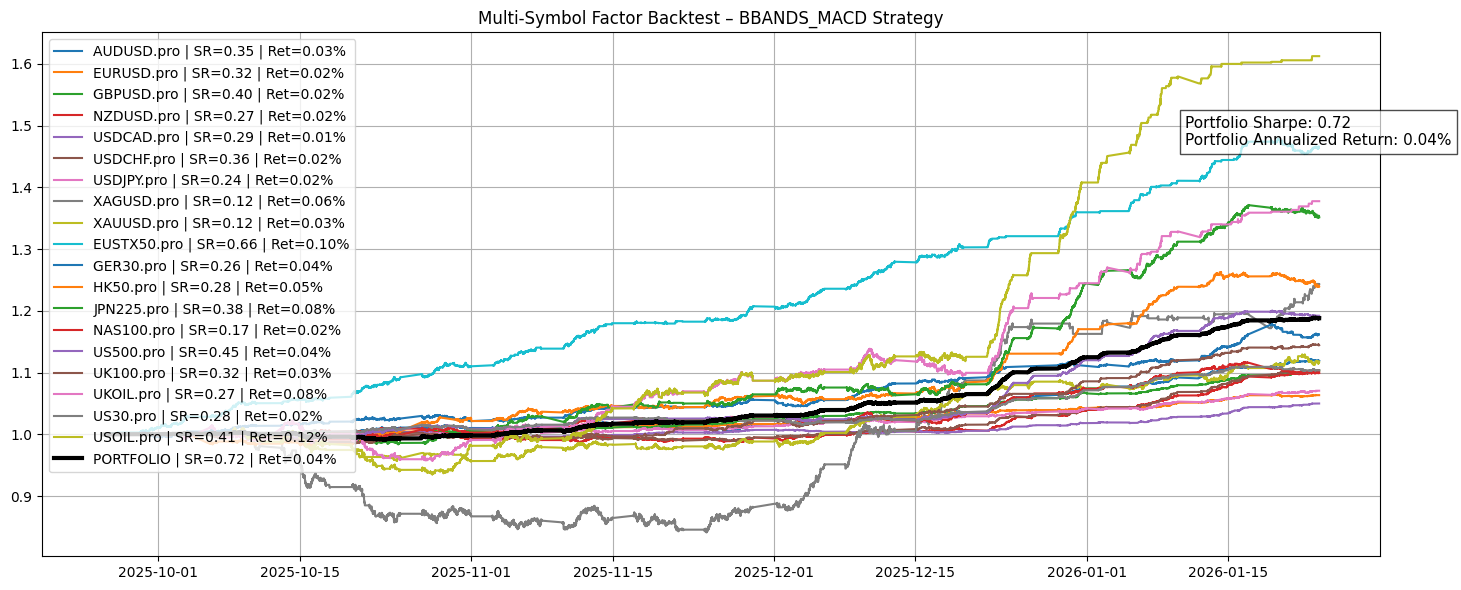

In [2]:

import MetaTrader5 as mt5
import pandas as pd
from backtest import backtest_symbols, fetch_mt5_data

factors = ["ma", "bbands", "macd", "bbands_macd"]

all_perfs = []   # store only the performance part
timeframe = mt5.TIMEFRAME_M1
for factor in factors:
    perf, _ = backtest_symbols(
        symbols,
        factor=factor,
        timeframe=timeframe
    )
    
    perf["Factor"] = factor.upper()   # tag it
    all_perfs.append(perf)

In [3]:
# all_perfs is a list of DataFrames:
# [perf_ma, perf_bbands, perf_macd, perf_rsi, ...]

# 1. Combine everything into one DataFrame
combined = pd.concat(all_perfs, ignore_index=True)

# 2. Convert Sharpe to absolute value
combined["AbsSharpe"] = combined["Sharpe"].abs()

# 3. Select the row with the highest absolute Sharpe for each symbol
best_per_symbol = combined.loc[
    combined.groupby("Symbol")["AbsSharpe"].idxmax()
].reset_index(drop=True)

print(best_per_symbol)

         Symbol    Sharpe  Annualized Return       Factor  AbsSharpe
0    AUDUSD.pro  0.387686           0.000601       BBANDS   0.387686
1    EURUSD.pro  0.388949           0.000404       BBANDS   0.388949
2   EUSTX50.pro  0.904474           0.002733       BBANDS   0.904474
3    GBPUSD.pro  0.404608           0.000248  BBANDS_MACD   0.404608
4     GER30.pro  0.263996           0.000380  BBANDS_MACD   0.263996
5      HK50.pro  0.400408           0.001729       BBANDS   0.400408
6    JPN225.pro  0.376012           0.000762  BBANDS_MACD   0.376012
7    NAS100.pro  0.169504           0.000240  BBANDS_MACD   0.169504
8    NZDUSD.pro  0.522803           0.000861       BBANDS   0.522803
9     UK100.pro  0.368786           0.000783       BBANDS   0.368786
10    UKOIL.pro  0.739390           0.004408       BBANDS   0.739390
11     US30.pro  0.283980           0.000249  BBANDS_MACD   0.283980
12    US500.pro  0.445501           0.000444  BBANDS_MACD   0.445501
13   USDCAD.pro  0.474129         

In [4]:
import MetaTrader5 as mt5
import pandas as pd 
from factorsignal import generate_signal


df = fetch_mt5_data(symbol=symbols[1], timeframe=timeframe)[0]
signal = generate_signal(df, factor=factor)

sig_prev = signal.shift(1)
steps = (signal - sig_prev).abs().fillna(0).astype(int)

counts = steps.value_counts().sort_index()
print(counts)
no_transition = (steps == 0).sum()
one_step      = (steps == 1).sum()
two_steps     = (steps == 2).sum()

print("No transition:", no_transition)
print("1-step transitions:", one_step)
print("2-step transitions:", two_steps)

0    88024
1    11902
2       73
Name: count, dtype: int64
No transition: 88024
1-step transitions: 11902
2-step transitions: 73


In [5]:
sumret = perf["Annualized Return"].abs().sum()
print(f"Sum of annualized returns: {sumret:0.6%}")

returns_factor_pr = returns_factor_pr.dropna()
import numpy as np
# Covariance matrix
cov = returns_factor_pr.cov()

# Equal weights
n = len(returns_factor_pr.columns)
weights = np.ones(n) / n

# Portfolio volatility
p_vol = np.sqrt(weights.T @ cov.values @ weights)

# Portfolio return
asset_means = returns_factor_pr.mean()
p_return = np.dot(weights, asset_means)

# Annualize
p_return_annual = p_return * 252
p_vol_annual = p_vol * np.sqrt(252)

# Portfolio Sharpe
portfolio_sharpe = p_return_annual / p_vol_annual

print(f"Portfolio Annual Return: {p_return_annual:0.4%}")
print(f"Portfolio Annual Volatility: {p_vol_annual:0.4%}")
print(f"Portfolio Sharpe: {portfolio_sharpe:0.4f}")

Sum of annualized returns: 0.826400%
Portfolio Annual Return: 0.0323%
Portfolio Annual Volatility: 0.0405%
Portfolio Sharpe: 0.7962
